In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.spatial import ConvexHull

import sys

import matplotlib

font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

sys.path.append("../../util/")
from util import get_points_near_line


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

DATA_DIR = "/Users/andrewjones/Documents/beehive/spatial-imputation/data/visium"
N_GENES = 100

## Load data
adata = sc.read_visium(DATA_DIR)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=N_GENES, subset=True)


genes = adata[:, adata.var.highly_variable].var_names.values[:100]
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    # genes=genes,
    # n_perms=100,
    # n_jobs=1,
)
moran_scores = adata.uns["moranI"]
top_gene_name = adata.uns["moranI"].index.values[0]

## Extract and normalize/standardize data
X = adata.obsm["spatial"].astype(float)
Y = np.array(adata[:, top_gene_name].X.todense()).squeeze()

X -= X.min(0)
X /= X.max(0)
X *= 10
X -= 5

Y = (Y - Y.mean()) / Y.std()
# Y = mvn.rvs(mean=np.zeros(len(X)), cov=RBF()(X) + 1e-2 * np.eye(len(X)))

/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


#cells after MT filter: 2998


/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


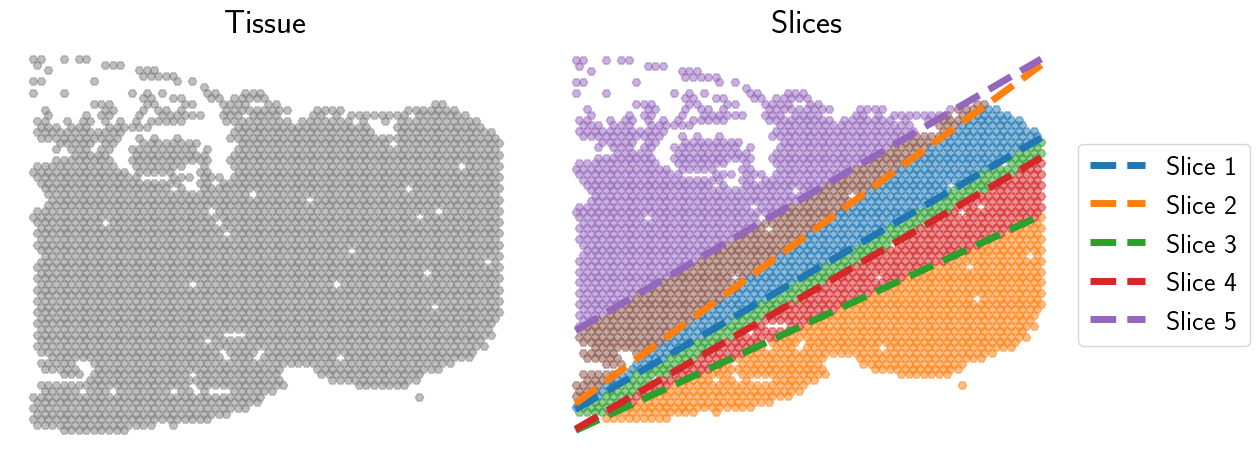

In [3]:

n_iters = 5
# kernel = RBF(length_scale=1.0, length_scale_bounds="fixed") + WhiteKernel(
#     noise_level=1, noise_level_bounds="fixed"
# )
kernel = RBF() + WhiteKernel()

# When we take a slice, all points within this
# distance to the line/plane are "observed"
slice_radius = 0.25
n_candidate_designs = 20

designs = []
observations = []
observed_idx = []
X_fragment_idx = [np.arange(len(X))]


# Discretize design space
n_slope_discretizations = 30
n_intercept_discretizations = 30
slope_angles = np.linspace(0, np.pi, n_slope_discretizations)
slopes = np.tan(slope_angles)
intercepts = np.linspace(
    np.min(X[:, 0]) + 1, np.max(X[:, 0]) - 1, n_intercept_discretizations
)
designs1, designs2 = np.meshgrid(intercepts, slopes)
candidate_designs = np.vstack([designs1.ravel(), designs2.ravel()]).T

# candidate_designs = np.vstack([intercepts, np.zeros(n_slope_discretizations)]).T
n_candidate_designs = len(candidate_designs)


observed_idx = []

for iternum in range(n_iters):

    assert len(designs) == iternum
    assert len(X_fragment_idx) == iternum + 1

    # logdets = np.zeros(n_candidate_designs) - np.inf
    # num_xs = np.zeros(n_candidate_designs)

    # print(observed_idx)
    if len(observed_idx) > 0:
        gpr = GPR(kernel=kernel)
        gpr.fit(
            X[np.unique(observed_idx)],
            Y[np.unique(observed_idx)],
        )

    best_eig = -np.inf
    best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

    for ff in range(len(X_fragment_idx)):

        # Get data for this fragment
        curr_X = X[X_fragment_idx[ff]]

        eigs = []
        logdets = np.zeros(n_candidate_designs) - np.inf
        for dd in range(n_candidate_designs):

            # Get points that would be observed by this slice
            curr_design = candidate_designs[dd]

            above_fragment_idx = np.where(
                curr_X[:, 1] >= curr_design[0] + curr_X[:, 0] * curr_design[1]
            )[0]

            if len(above_fragment_idx) in [
                0,
                1,
                2,
                len(curr_X),
                len(curr_X) - 1,
                len(curr_X) - 2,
            ]:
                continue

            curr_observed_idx = get_points_near_line(
                X=curr_X,
                slope=curr_design[1],
                intercept=curr_design[0],
                slice_radius=slice_radius,
            )
            if len(curr_observed_idx) == 0:
                continue

            L = len(curr_observed_idx)

            if iternum == 0:
                cov = kernel(curr_X[curr_observed_idx])
                # curr_eig = mvn_entropy(cov)
                noise_variance = np.exp(kernel.k2.theta[0])
                # import ipdb; ipdb.set_trace()
            else:
                # Make predictions of expression
                _, cov = gpr.predict(curr_X[curr_observed_idx], return_cov=True)

                noise_variance = np.exp(gpr.kernel_.k2.theta[0])

            curr_eig = 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(L))[1]

            if curr_eig > best_eig:
                best_design_idx = dd
                best_fragment_idx = ff
                best_observed_idx = X_fragment_idx[ff][curr_observed_idx]
                best_eig = curr_eig

    curr_best_design = candidate_designs[best_design_idx]

    # print(best_fragment_idx)
    best_fragment_X = X[X_fragment_idx[best_fragment_idx]]

    above_fragment_idx = np.where(
        best_fragment_X[:, 1]
        >= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
    )[0]
    below_fragment_idx = np.where(
        best_fragment_X[:, 1]
        <= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
    )[0]

    above_idx = X_fragment_idx[best_fragment_idx][above_fragment_idx]
    below_idx = X_fragment_idx[best_fragment_idx][below_fragment_idx]
    X_fragment_idx.pop(best_fragment_idx)
    X_fragment_idx.append(above_idx)
    X_fragment_idx.append(below_idx)

    designs.append(curr_best_design)
    observed_idx.extend(best_observed_idx)
    # import ipdb; ipdb.set_trace()

    # plt.figure(figsize=(7, 5))
    # plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.3, marker="H")
    # plt.scatter(
    #     X[observed_idx, 0],
    #     X[observed_idx, 1],
    #     c=Y[observed_idx],
    #     vmin=np.min(Y),
    #     vmax=np.max(Y),
    # )
    # plt.show()

    # plt.figure(figsize=(7, 5))
    # if iternum > 0:
    #     plt.scatter(X[:, 0], X[:, 1], c=gpr.predict(X, return_std=True)[1])
    # else:
    #     plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.3)
    # plt.xlim([-5, 5])
    # plt.ylim([-5, 5])
    # plt.show()

    # import ipdb; ipdb.set_trace()


designs = np.stack(designs, axis=0)


plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5, marker="H")
plt.title("Tissue")
plt.axis("off")

plt.subplot(122)
# plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5, marker="H")
colors = plt.cm.jet(np.linspace(0, 1, n_iters + 1))
for ii in range(n_iters + 1):

    curr_X = X[X_fragment_idx[ii]]

    hull = ConvexHull(curr_X)
    plt.scatter(hull.points[:, 0], hull.points[:, 1], alpha=0.5, marker="H")
    # import ipdb; ipdb.set_trace()

    # plt.fill(
    #     curr_X[hull.vertices, 0],
    #     curr_X[hull.vertices, 1],
    #     "k",
    #     alpha=0.3,
    #     color=colors[ii],
    # )


Xmin, Xmax = X[:, 0].min(), X[:, 0].max()
for dd in range(len(designs)):
    curr_intercept, curr_slope = designs[dd]
    plt.plot(
        np.array([Xmin, Xmax]),
        np.array(
            [
                curr_intercept + curr_slope * Xmin,
                curr_intercept + curr_slope * Xmax,
            ]
        ),
        linewidth=5,
        linestyle="--",
        label="Slice {}".format(dd + 1),
        # color="black"
    )

plt.title("Slices")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.axis("off")

plt.tight_layout()
plt.savefig("./out/visium_slicing_experiment_fragments.png")
plt.show()
